## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [10]:
import os
import keras
import tensorflow
from keras.datasets import cifar10

import matplotlib.pyplot as plt
%matplotlib inline


# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512 

/home/wanzi/ml/cupoyMarathon/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-11-22 14:08:12.791579: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/50
49/49 [==============================] - 6s 77ms/step - loss: 2.1942 - accuracy: 0.2747 - val_loss: 2.1013 - val_accuracy: 0.2263
Epoch 2/50
49/49 [==============================] - 4s 76ms/step - loss: 1.7442 - accuracy: 0.3940 - val_loss: 1.9692 - val_accuracy: 0.2908
Epoch 3/50
49/49 [==============================] - 3s 71ms/step - loss: 1.6119 - accuracy: 0.4380 - val_loss: 1.8459 - val_accuracy: 0.3521
Epoch 4/50
49/49 [==============================] - 4s 75ms/step - loss: 1.5369 - accuracy: 0.4613 - val_loss: 1.7414 - val_accuracy: 0.3894
Epoch 5/50
49/49 [==============================] - 4s 75ms/step - loss: 1.4787 - accuracy: 0.4840 - val_loss: 1.6491 - val_accuracy: 0.4197
Epoch 6/50
49/49 [==============================] - 4s 76ms/step - loss: 1.4321 - accuracy: 0.4986 - val_loss: 1.6023 - val_accuracy: 0.4283
Epoch 7/50
49/49 [==============================] - 3s 71ms/step - loss: 1.3919 - accuracy: 0.5140 - val_loss: 1.5502 - val_accuracy: 0.4454
Epoch 8/50
49

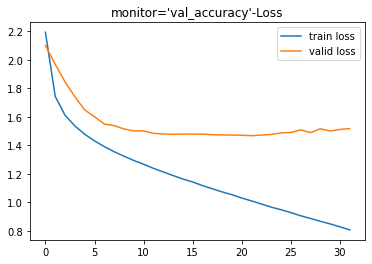

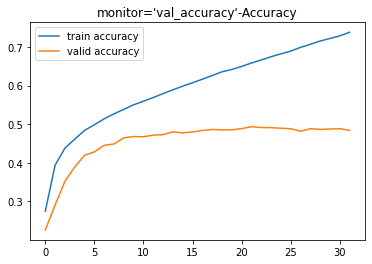

In [11]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""

"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation accuracy

參數說明：
patience: 經過多少epochs後仍然沒有改善模型效能時停止訓練。
verbose: 運作狀況

使用說明：先定義出 Early stopping 的規則，再放入模型訓練中。

"""

results = {}

from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_accuracy", 
                          patience=10, 
                          verbose=1
                          )

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.gradient_descent_v2.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop]
         )

   # Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]        

exp_name_tag = ("EarlyStopping- monitor='val_accuracy'")
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("monitor='val_accuracy'-Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("monitor='val_accuracy'-Accuracy")
plt.show()

### monitor="val_loss", patience=10

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512 

2021-11-22 14:17:56.050482: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/50
49/49 [==============================] - 5s 83ms/step - loss: 2.2095 - accuracy: 0.2671 - val_loss: 2.1385 - val_accuracy: 0.1670
Epoch 2/50
49/49 [==============================] - 4s 83ms/step - loss: 1.7407 - accuracy: 0.3924 - val_loss: 1.9786 - val_accuracy: 0.2578
Epoch 3/50
49/49 [==============================] - 4s 91ms/step - loss: 1.6223 - accuracy: 0.4340 - val_loss: 1.8523 - val_accuracy: 0.3401
Epoch 4/50
49/49 [==============================] - 4s 90ms/step - loss: 1.5507 - accuracy: 0.4563 - val_loss: 1.7620 - val_accuracy: 0.3806
Epoch 5/50
49/49 [==============================] - 4s 82ms/step - loss: 1.4970 - accuracy: 0.4760 - val_loss: 1.6585 - val_accuracy: 0.4263
Epoch 6/50
49/49 [==============================] - 4s 78ms/step - loss: 1.4521 - accuracy: 0.4919 - val_loss: 1.5925 - val_accuracy: 0.4431
Epoch 7/50
49/49 [==============================] - 5s 110ms/step - loss: 1.4133 - accuracy: 0.5060 - val_loss: 1.5438 - val_accuracy: 0.4581
Epoch 8/50
4

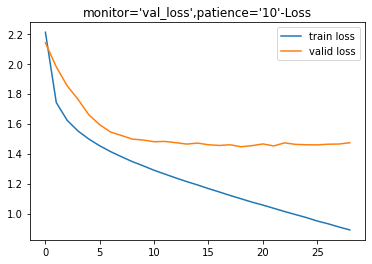

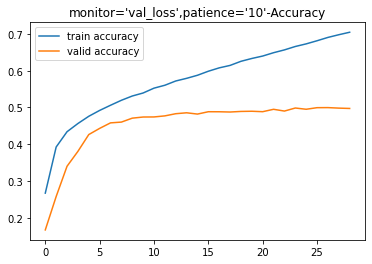

In [12]:
earlystop = EarlyStopping(monitor="val_loss", 
                          patience=10, 
                          verbose=1
                          )

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.gradient_descent_v2.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop]
         )

# Collect results
train_loss_2 = model.history.history["loss"]
valid_loss_2 = model.history.history["val_loss"]
train_acc_2 = model.history.history["accuracy"]
valid_acc_2 = model.history.history["val_accuracy"]


exp_name_tag = ("EarlyStopping- monitor='val_loss', patience='10'")
results[exp_name_tag] = {'train-loss': train_loss_2,
                         'valid-loss': valid_loss_2,
                         'train-acc': train_acc_2,
                         'valid-acc': valid_acc_2}

plt.plot(range(len(train_loss_2)), train_loss_2, label="train loss")
plt.plot(range(len(valid_loss_2)), valid_loss_2, label="valid loss")
plt.legend()
plt.title("monitor='val_loss',patience='10'-Loss")
plt.show()

plt.plot(range(len(train_acc_2)), train_acc_2, label="train accuracy")
plt.plot(range(len(valid_acc_2)), valid_acc_2, label="valid accuracy")
plt.legend()
plt.title("monitor='val_loss',patience='10'-Accuracy")
plt.show()

### monitor="val_loss", patience=25

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_12 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_14 (Batc (None, 128)               512 

2021-11-22 14:25:08.793068: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/50
49/49 [==============================] - 6s 88ms/step - loss: 2.2055 - accuracy: 0.2751 - val_loss: 2.0835 - val_accuracy: 0.2329
Epoch 2/50
49/49 [==============================] - 4s 78ms/step - loss: 1.7315 - accuracy: 0.3967 - val_loss: 1.9556 - val_accuracy: 0.2917
Epoch 3/50
49/49 [==============================] - 4s 80ms/step - loss: 1.6098 - accuracy: 0.4370 - val_loss: 1.8147 - val_accuracy: 0.3558
Epoch 4/50
49/49 [==============================] - 4s 84ms/step - loss: 1.5390 - accuracy: 0.4611 - val_loss: 1.7291 - val_accuracy: 0.3878
Epoch 5/50
49/49 [==============================] - 4s 86ms/step - loss: 1.4856 - accuracy: 0.4803 - val_loss: 1.6536 - val_accuracy: 0.4167
Epoch 6/50
49/49 [==============================] - 4s 79ms/step - loss: 1.4417 - accuracy: 0.4961 - val_loss: 1.5903 - val_accuracy: 0.4384
Epoch 7/50
49/49 [==============================] - 4s 79ms/step - loss: 1.4035 - accuracy: 0.5116 - val_loss: 1.5557 - val_accuracy: 0.4486
Epoch 8/50
49

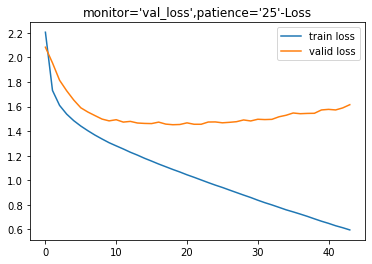

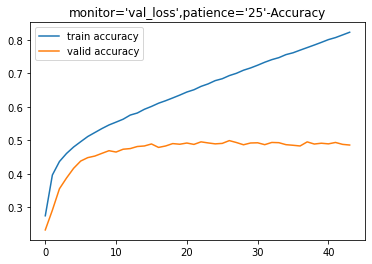

In [13]:
earlystop = EarlyStopping(monitor="val_loss", 
                          patience=25, 
                          verbose=1
                          )

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.gradient_descent_v2.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop]
         )

# Collect results
train_loss_3 = model.history.history["loss"]
valid_loss_3 = model.history.history["val_loss"]
train_acc_3 = model.history.history["accuracy"]
valid_acc_3 = model.history.history["val_accuracy"]


exp_name_tag = ("EarlyStopping- monitor='val_loss', patience='25'")
results[exp_name_tag] = {'train-loss': train_loss_3,
                         'valid-loss': valid_loss_3,
                         'train-acc': train_acc_3,
                         'valid-acc': valid_acc_3}


plt.plot(range(len(train_loss_3)), train_loss_3, label="train loss")
plt.plot(range(len(valid_loss_3)), valid_loss_3, label="valid loss")
plt.legend()
plt.title("monitor='val_loss',patience='25'-Loss")
plt.show()

plt.plot(range(len(train_acc_3)), train_acc_3, label="train accuracy")
plt.plot(range(len(valid_acc_3)), valid_acc_3, label="valid accuracy")
plt.legend()
plt.title("monitor='val_loss',patience='25'-Accuracy")
plt.show()

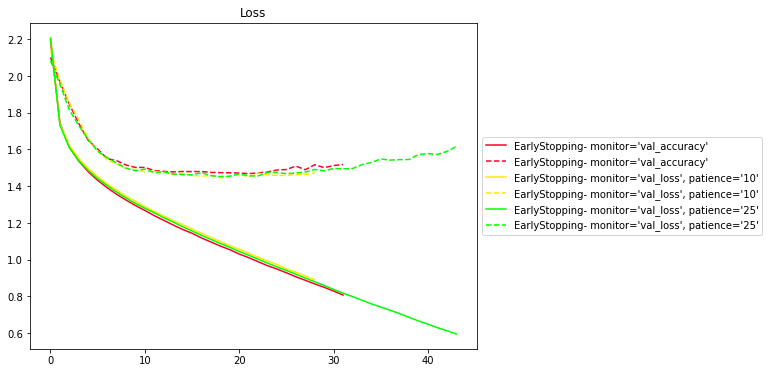

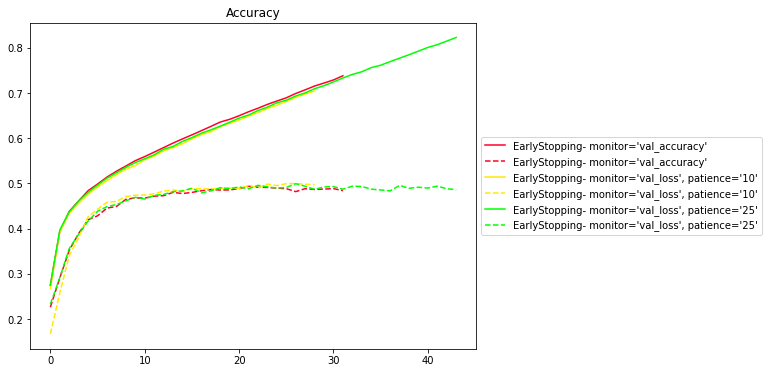

In [14]:

import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 6

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

